In [37]:
import urbanpy as up
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians

# Adquisicion de datos

## Limites de la ciudad

In [2]:
sjl_poly = up.download.download_osm(0, 'San Juan de Lurigancho, Lima')

## Hexagonos de la cuidad

In [3]:
sjl_hexs, sjl_hexs_centroids = up.geom.gen_hexagons(9, sjl_poly)

## Poblacion estimada por hexagono

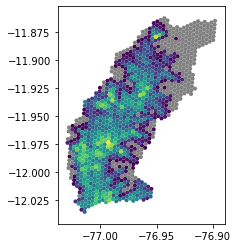

In [4]:
pop_peru = up.download.download_hdx("4e74db39-87f1-4383-9255-eaf8ebceb0c9/resource/317f1c39-8417-4bde-a076-99bd37feefce/download/population_per_2018-10-01.csv.zip")
pop_sjl = up.geom.filter_population(pop_peru, sjl_poly)

sjl_hexs_pop = up.geom.merge_shape_hex(sjl_hexs, pop_sjl, how='inner', op='within', agg={'population_2020': 'sum'})
sjl_hexs_pop.plot(column='population_2020', missing_kwds={'color': 'grey'})

## Datos geoespaciales de mercados & posibles mercados (parques y lozas)

In [5]:
sjl_markets =  gpd.read_file('inputs/flp_sjl/selected_facilities_sjl.shp') # contains markets & possible markets positions

In [6]:
# Get all activated markets positions
sjl_active_markets = sjl_markets[sjl_markets['active']==1]
sjl_active_markets.shape

(135, 7)

In [7]:
# Get old markets positions
sjl_old_markets = sjl_markets[sjl_markets['is_market']==1]
sjl_old_markets.shape

(122, 7)

In [8]:
# Get possible markets positions
sjl_possible_markets = sjl_markets[sjl_markets['is_market']==0]
sjl_possible_markets.shape

(707, 7)

In [9]:
# Get selected possible markets positions
sjl_new_markets = sjl_markets[(sjl_markets['is_market']==0) & (sjl_markets['active']==1)]
sjl_new_markets.shape

(13, 7)

# Calculo de indicadores

## Movimiento (estimado) de personas por mercado

In [10]:
def get_movement_per_market(markets, pop_df, pop_column, coverage=400, markets_utm=True):
    # Calcula el area de cobertura de cada mercado
    df = markets.copy()
    if markets_utm:
        df['geometry'] = df.geometry.buffer(coverage)
        df = df.to_crs('EPSG:4326')
    else:
        df['geometry'] = df.geometry.buffer(distance=coverage/1e5) # approx 400m
        df = df.to_crs('EPSG:4326')


    # Identifica los hexagonos dentro de cada area de cobertura
    df_pop = gpd.sjoin(
        pop_df, 
        df, 
        how='inner', 
        op='intersects', 
    ).drop_duplicates(0) # handle duplicated hexagons that intersect with multiple markets coverage area
    
    pop_by_market = df_pop.groupby('index_right').sum().reset_index() # Agrega la poblacion por mercado segun el area de cobertura
    
    return pop_by_market[['index_right', pop_column]]

Primero calcularemos el indicador para el escenario actual (sin mercados itinerantes)

In [11]:
movement_per_old_market = get_movement_per_market(sjl_old_markets, sjl_hexs_pop, 'population_2020')
sjl_old_markets.loc[movement_per_old_market['index_right'], 'population'] = movement_per_old_market['population_2020'].values

/Users/cortega/Documents/COVID-19/VulnerabilityMaps_LimaLab_BID/.env/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/cortega/Documents/COVID-19/VulnerabilityMaps_LimaLab_BID/.env/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Ahora calcularemos el indicador para el escenario con mercados itinerantes seleccionados mediante la optimizacion

In [12]:
movement_per_new_market = get_movement_per_market(sjl_active_markets, sjl_hexs_pop, 'population_2020')
sjl_active_markets.loc[movement_per_new_market['index_right'], 'population'] = movement_per_new_market['population_2020'].values

/Users/cortega/Documents/COVID-19/VulnerabilityMaps_LimaLab_BID/.env/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/cortega/Documents/COVID-19/VulnerabilityMaps_LimaLab_BID/.env/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Vamos a calcular el indicador para un escenario en el cual los mercados itinerantes se hubieran elegido al azar

In [29]:
sjl_random_markets = pd.concat([
    sjl_old_markets,
    sjl_possible_markets.sample(13, random_state=60)
])

movement_per_random_market = get_movement_per_market(sjl_random_markets, sjl_hexs_pop, 'population_2020')
sjl_random_markets.loc[movement_per_random_market['index_right'], 'population'] = movement_per_random_market['population_2020'].values

Comparacion de estadisticas

In [30]:
actual_coverage_stats = sjl_old_markets['population'].describe()
actual_coverage_stats.name = 'Actual'

new_coverage_stats = sjl_active_markets['population'].describe()
new_coverage_stats.name = 'Con mercados itinerantes optimos'

random_coverage_stats = sjl_random_markets['population'].describe()
random_coverage_stats.name = 'Con mercados itinerantes aleatorios'

In [31]:
pop_mov_stats = pd.concat([
    actual_coverage_stats,
    new_coverage_stats,
    random_coverage_stats
], axis=1)

In [32]:
pop_mov_stats

,Actual,Con mercados itinerantes optimos,Con mercados itinerantes aleatorios
count,87.000000,96.000000,94.000000
mean,9449.900214,9325.867819,9026.194126
std,6855.952633,6819.011806,6773.647812
min,947.154650,947.154650,947.154650
25%,3938.169333,3776.156038,3477.054570
50%,7577.237198,7602.162321,7053.809629
75%,13908.218279,12537.336549,13474.552921
max,29262.093655,29262.093655,29262.093655


Se puede observar que en la mayoría de estadísticos **(promedio, mínimo, mediana, tercer cuartil (75%)) mejora (se reduce) la cantidad de personas por mercado en comparacion con el escenario actual.**  

Por otro lado los mercados seleccionados mediante la optimizacion tienen **mejores (menores) valores de minimo, mediana y tercer cuartil (75%) que los mercados itinerantes seleccionados aleatoriamente.**

No handles with labels found to put in legend.


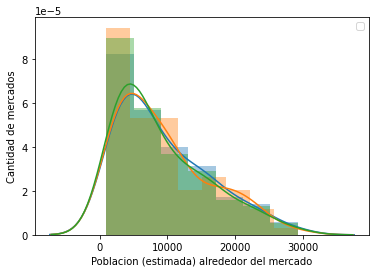

In [33]:
g = sns.distplot(sjl_old_markets['population'], hist=True, norm_hist=False)
sns.distplot(sjl_active_markets['population'], hist=True,  ax=g,norm_hist=False)
sns.distplot(sjl_random_markets['population'], hist=True,  ax=g,norm_hist=False)

plt.grid(False)
plt.title('')
plt.ylabel('Cantidad de mercados')
plt.xlabel('Poblacion (estimada) alrededor del mercado')

plt.legend()
plt.show()

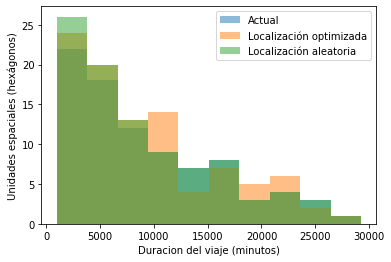

In [34]:
# Comparacion de histograma
ax = sjl_old_markets.hist(column='population', alpha=0.5, label='Actual')
sjl_active_markets.hist(column='population', alpha=0.5, ax=ax, label='Localización optimizada')
sjl_random_markets.hist(column='population', alpha=0.5, ax=ax, label='Localización aleatoria')

plt.grid(False)
plt.title('')
plt.ylabel('Unidades espaciales (hexágonos)')
plt.xlabel('Duracion del viaje (minutos)')

plt.legend()
plt.show()

# Distancia y Duracion de viaje

"The average human walking speed at crosswalks is about 5.0 kilometres per hour (km/h), or about 1.4 meters per second (m/s), or about 3.1 miles per hour (mph)" (https://en.wikipedia.org/wiki/Walking).

In [35]:
def get_trips(markets, points):
    markets_, points_ = markets.copy(), points.copy()
    
    # Calc radians
    points_['lon'], points_['lat'] = points_.geometry.x, points_.geometry.y
    points_[['lat_radians', 'lon_radians']] = points_[['lat','lon']].applymap(radians)
    
    markets_[['lat_radians', 'lon_radians']] = markets_[['lat','lon']].applymap(radians)
    
    # Calc shortest distance from hex to market
    distance = up.utils.nn_search(
        markets_[['lat_radians','lon_radians']], 
        points_[['lat_radians','lon_radians']],
        metric = 'manhattan'
    )
    
    duration = (distance/5)*60 # in minutes
    distance = distance*1000 # in meters
    
    inds = pd.DataFrame(
        data = np.concatenate((distance, duration), axis=1),
        columns = ['trip_distance', 'trip_duration'],
        index = points.index
    )
    
    return inds

In [38]:
trips_old = get_trips(sjl_old_markets, sjl_hexs_centroids) # Actual 
trips_new = get_trips(sjl_active_markets, sjl_hexs_centroids) # Optimized
trips_random = get_trips(sjl_random_markets, sjl_hexs_centroids) # Random

# Comparamos los dos escenarios

In [39]:
trips_old_stats = trips_old.describe()
trips_old_stats.name = 'Actual'

trips_new_stats = trips_new.describe()
trips_new_stats.name = 'Con mercados itinerantes optimos'

trips_random_stats = trips_random.describe()
trips_random_stats.name = 'Con mercados itinerantes aleatorios'

In [40]:
arrays = [['Distancia (en metros)', 'Distancia (en metros)', 'Distancia (en metros)', 'Duración (en minutos)', 'Duración (en minutos)', 'Duración (en minutos)'],
          ['Actual', 'Con mercados itinerantes optimos', 'Con mercados itinerantes aleatorios', 'Actual', 'Con mercados itinerantes optimos', 'Con mercados itinerantes aleatorios',]]

tuples = list(zip(*arrays))

index = pd.MultiIndex.from_tuples(tuples, names=['Indicador', 'Escenario'])

In [41]:
stats = pd.concat([
    trips_old_stats['trip_distance'],
    trips_new_stats['trip_distance'],
    trips_random_stats['trip_distance'],
    trips_old_stats['trip_duration'],
    trips_new_stats['trip_duration'],
    trips_random_stats['trip_duration']
], axis=1)


In [42]:
pd.DataFrame(columns=index, data = stats.values, index=stats.index)

Indicador Distancia (en metros)                                   \
Escenario                Actual Con mercados itinerantes optimos   
count               1125.000000                      1125.000000   
mean                2150.021870                      1896.120968   
std                 2172.917354                      2109.019101   
min                   33.548314                        33.548314   
25%                  532.641936                       454.048410   
50%                 1346.300987                      1018.320239   
75%                 3002.044589                      2550.913448   
max                10902.331594                     10902.331594   

Indicador                                     Duración (en minutos)  \
Escenario Con mercados itinerantes aleatorios                Actual   
count                             1125.000000           1125.000000   
mean                              2120.606795             25.800262   
std                               2180.115073             26.075008   
min                                 33.548314              0.402580   
25%                                510.504562              6.391703   
50%                               1279.380791             16.155612   
75%                               2989.997696             36.024535   
max                              10902.331594            130.827979   

Indicador                                                                       
Escenario Con mercados itinerantes optimos Con mercados itinerantes aleatorios  
count                          1125.000000                         1125.000000  
mean                             22.753452                           25.447282  
std                              25.308229                           26.161381  
min                               0.402580                            0.402580  
25%                               5.448581                            6.126055  
50%                              12.219843                           15.352569  
75%                              30.610961                           35.879972  
max                             130.827979                          130.827979

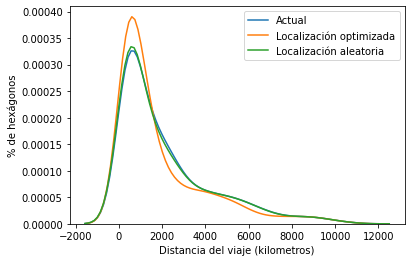

In [43]:
g = sns.distplot(trips_old['trip_distance'], hist=False, label='Actual')
sns.distplot(trips_new['trip_distance'], hist=False, label='Localización optimizada', ax=g)
sns.distplot(trips_random['trip_distance'], hist=False, label='Localización aleatoria',  ax=g)

plt.grid(False)
plt.title('')
plt.ylabel('% de hexágonos')
plt.xlabel('Distancia del viaje (kilometros)')

plt.legend()
plt.show()

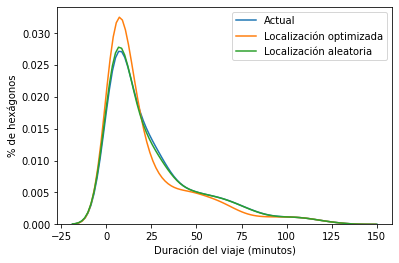

In [44]:
g = sns.distplot(trips_old['trip_duration'], hist=False, label='Actual')
sns.distplot(trips_new['trip_duration'], hist=False, label='Localización optimizada', ax=g)
sns.distplot(trips_random['trip_duration'], hist=False, label='Localización aleatoria',  ax=g)

plt.grid(False)
plt.title('')
plt.ylabel('% de hexágonos')
plt.xlabel('Duración del viaje (minutos)')

plt.legend()
plt.show()